In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

# Análisis de E-commerce OLIST

Diego Alexander Rueda Plata
ing.diegorueda@gmail.com

Datos obtenidos de: https://www.kaggle.com/olistbr/brazilian-ecommerce

## Delivery Performance - Introducción

OLIST es una plataforma de ventas muy popular en Brazil, que permite conectar negocios pequeños de todo el país. 
Estos comerciantes pueden vender sus productos a través de OLIST y enviarlos directamente a los clientes usando socios de logística de OLIST.

Cuando un cliente recibe un producto, o la fecha estimada de entrega se ha superado, el cliente recibe una encuesta de satisfacción donde podrá calificar la experiencia de compra.

Dada la importancia de una entrega a tiempo en la experiencia del cliente, es de gran importancia que se identifiquen las tendencias y características que puedan dificultar o retrasar la entrega de los productos.

El enfoque de este notebook estará en encontrar fuentes de optimización en los tiempos de entrega,
y determinar la posibilidad de desarrollar un modelo que permita predecir los tiempos estimados de entrega reales.

## Preprocesamiento de Datos

In [2]:
dataset = {
    'customers' : pd.read_csv('archive/olist_customers_dataset.csv'),
    'orders' : pd.read_csv('archive/olist_orders_dataset.csv'),
    'order_items' : pd.read_csv('archive/olist_order_items_dataset.csv'),
    'products' : pd.read_csv('archive/olist_products_dataset.csv'),
    'products_english' : pd.read_csv('archive/product_category_name_translation.csv'),
    'order_payments': pd.read_csv('archive/olist_order_payments_dataset.csv'),
    'sellers' : pd.read_csv('archive/olist_sellers_dataset.csv'),
    'reviews': pd.read_csv('archive/olist_order_reviews_dataset.csv')
}

### Inspeccionar tipos de datos

In [3]:
for df in dataset.keys():
    print(dataset[df].dtypes)
    print('\n')

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object


order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object


order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object


product_id                     object
product_category_name          object
product_name_lenght           float64
product_description_lenght    float64
product_photos_qty            float64
product_weight_g              float64
product_leng

- Las columnas que representan fechas y momentos en el tiempo no son interpretadas, por lo que es necesario transformarlas para facilitar los cálculos sobre estas entradas.

In [4]:
# ORDERS
dataset['orders']['order_purchase_timestamp'] = pd.to_datetime(dataset['orders']['order_purchase_timestamp'])
dataset['orders']['order_approved_at'] = pd.to_datetime(dataset['orders']['order_approved_at'])
dataset['orders']['order_delivered_carrier_date'] = pd.to_datetime(dataset['orders']['order_delivered_carrier_date'])
dataset['orders']['order_delivered_customer_date'] = pd.to_datetime(dataset['orders']['order_delivered_customer_date'])
dataset['orders']['order_estimated_delivery_date'] = pd.to_datetime(dataset['orders']['order_estimated_delivery_date'])

# ORDER ITEMS
dataset['order_items']['shipping_limit_date'] = pd.to_datetime(dataset['order_items']['shipping_limit_date'])

print(dataset['orders'].dtypes)
print('\n')
print(dataset['order_items'].dtypes)

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object


order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object


### Revisar datos faltantes

In [5]:
def check_missing_values(name):
    df = dataset[name]
    # Any missing values in the dataframe?
    if df.isnull().any().sum():
        print(f'Dataframe: {name} - {len(df)} entries.')
        # Show me where
        print(df.isnull().sum())
        print('\n')
        

for df in dataset.keys():
    check_missing_values(df)

Dataframe: orders - 99441 entries.
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64


Dataframe: products - 32951 entries.
product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64


Dataframe: reviews - 100000 entries.
review_id                      0
order_id                       0
review_score                   0
review_comment_title       88285
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64




- Existen entradas faltantes en **orders**, es muy posible que esto se deba a que son órdenes que se encuentran en tránsito hacia el cliente y al momento de creación de este dataset no se habían reportado. Dado que el enfoque de este notebook es investigar si existen problemas en las entregas, de momento solo se consideran las ordenes con una fecha de entrega definida.

- En la tabla de **products** existen entradas sin categoría definida, de momento la mejor opción para tratar con este tipo de entradas es asignarlas a una categoría "No Definida" en lugar de eliminarlas.

- En **reviews** tambien se encuentra una gran cantidad de entradas ausentes en el título y cuerpo del mensaje, no es de extrañar la mayoría de usuarios no se toma la molestia de dejar un mensaje completo y solo califica la entrega según los puntajes establecidos [1-5].

Podemos eliminar estas entradas, o reemplazarlas por un valor estandar.

In [6]:
dataset['orders'].dropna(inplace=True)

dataset['products'].product_category_name.fillna('No Definida', inplace=True)
dataset['products'].product_description_lenght.fillna(0, inplace=True)
dataset['products'].product_name_lenght.fillna(0, inplace=True)
dataset['products'].product_photos_qty.fillna(0, inplace=True)
dataset['products'].fillna(0, inplace=True)

dataset['reviews'].drop(['review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp'], axis=1, inplace=True)

In [7]:
print('Notese que ya no existen entradas faltantes en el conjunto de datos.')
for df in dataset.keys():
    check_missing_values(df)

Notese que ya no existen entradas faltantes en el conjunto de datos.


### Revisar Datos Incongruentes

En particular las fechas presentes en la tabla de **orders** deben llevar el siguiente sentido:

1. order_purchase_timestamp (Instante en que se hace la compra)
2. order_approved_at (Instante en que se aprueba la compra)
3. order_delivered_carrier_date (Fecha en que el producto se entrega al socio de logística)
4. order_delivered_customer_date (Fecha en que el producto se entrega al cliente)
5. order_estimated_delivery_date (Fecha estimada de entrega al cliente)

La fecha estimada no interfiere en la lógica de las entregas, pero los demás instantes deben asegurar ese orden de menor a mayor.

In [8]:
# Ordenes donde el momento de compra es mayor al momento de aprobación
order_purchase_after_approval = len(dataset['orders'].loc[dataset['orders']['order_purchase_timestamp'] > dataset['orders']['order_approved_at']])
print(f'There are {order_purchase_after_approval} orders where approval is dated before purchase is done.')

There are 0 orders where approval is dated before purchase is done.


In [9]:
# Ordenes donde el momento de aprobación es mayor al momento de entrega al socio de logística
orders_approval_after_carrier_delivery = len(dataset['orders'].loc[dataset['orders']['order_approved_at'] > dataset['orders']['order_delivered_carrier_date']])
print(f'There are {orders_approval_after_carrier_delivery} orders where approval is dated after the items are delivered.')

There are 1350 orders where approval is dated after the items are delivered.


In [10]:
# Ordenes donde el momento de entrega al socio de logística es mayor al momento de entrega al cliente
orders_carrier_delivery_after_customer_delivery = len(dataset['orders'].loc[dataset['orders']['order_delivered_carrier_date'] > dataset['orders']['order_delivered_customer_date']])
print(f'There are {orders_carrier_delivery_after_customer_delivery} orders where logistic.')

There are 23 orders where logistic.


---

Existen 1373 ordenes donde las fechas no concuerdan con el sentido de las entregas, por lo tanto estas serán eliminadas antes de analizar el conjunto de datos.

Estos errores indicarían un fallo mas profundo en el almacenamiento de los datos que debería revisarse.

---

In [11]:
error_tipo_1 = dataset['orders'].loc[dataset['orders']['order_approved_at'] > dataset['orders']['order_delivered_carrier_date']]
error_tipo_2 = dataset['orders'].loc[dataset['orders']['order_delivered_carrier_date'] > dataset['orders']['order_delivered_customer_date']]

In [12]:
dataset['orders'] = dataset['orders'].drop(error_tipo_1.index).drop(error_tipo_2.index)

### Unificar Dataset

Para mayor facilidad en el manejo de los datos y dado que estos datos caben en la memoria de mi equipo actual, es posible unificar todos los datos de olist.

In [13]:
# convert products to english names, and drop the portuguese name
dataset['products'] = pd.merge(dataset['products'], dataset['products_english']).drop('product_category_name', axis=1)

# orders x order_items
olist_df = pd.merge(dataset['orders'], dataset['order_items'], how='left')

# orders x order_items x products
olist_df = pd.merge(olist_df, dataset['products'])

# orders x order_items x products x sellers x customers
olist_df = pd.merge(olist_df, dataset['sellers'])
olist_df = pd.merge(olist_df, dataset['customers'])

#  orders x order_items x products x sellers x customers x reviews
olist_df = pd.merge(olist_df, dataset['reviews'])

## Ingeniería de Características

Para analizar los tiempos desde el momento de aprobación hasta el momento de entrega, se crearan las siguientes características:

In [14]:
olist_df['days_from_approval_to_expected_delivery'] = (olist_df['order_estimated_delivery_date'] - olist_df['order_approved_at']).dt.days

olist_df['days_from_approval_to_customer_delivery'] = (olist_df['order_delivered_customer_date'] - olist_df['order_approved_at']).dt.days

olist_df['days_from_approval_to_carrier_delivery'] = (olist_df['order_delivered_carrier_date'] - olist_df['order_approved_at']).dt.days

olist_df['days_from_carrier_to_customer_delivery'] = (olist_df['order_delivered_customer_date'] - olist_df['order_delivered_carrier_date']).dt.days

olist_df['month_of_delivery_to_customer'] = olist_df['order_delivered_customer_date'].dt.month

olist_df['delivery_to_carrier_on_time'] = (olist_df['order_delivered_carrier_date'] < olist_df['shipping_limit_date'])

olist_df['delivery_to_customer_on_time'] = (olist_df['order_delivered_customer_date'] < olist_df['order_estimated_delivery_date'])

olist_df['same_state_delivery'] = (olist_df['seller_state'] == olist_df['customer_state'])

olist_df['same_city_delivery'] = (olist_df['seller_city'] == olist_df['customer_city'])

In [15]:
# Tambien creamos por separado un conjunto de datos que incluye los métodos de pago
olist_with_payments = pd.merge(olist_df, dataset['order_payments'])

### Eliminar columnas no necesarias para el análisis

In [16]:
olist_df.drop(['order_id','customer_id', 'product_id', 'seller_id', 'order_item_id', 'customer_unique_id', 'review_id'], axis=1, inplace=True)
olist_df.drop(['product_name_lenght', 'product_description_lenght', 'product_photos_qty'], axis=1, inplace=True)

In [17]:
# Dado que ya tenemos un dataset unificado podemos eliminar de la memoria al diccionario inicial
del dataset
import gc
gc.collect()

88

## Exploración Inicial de Datos

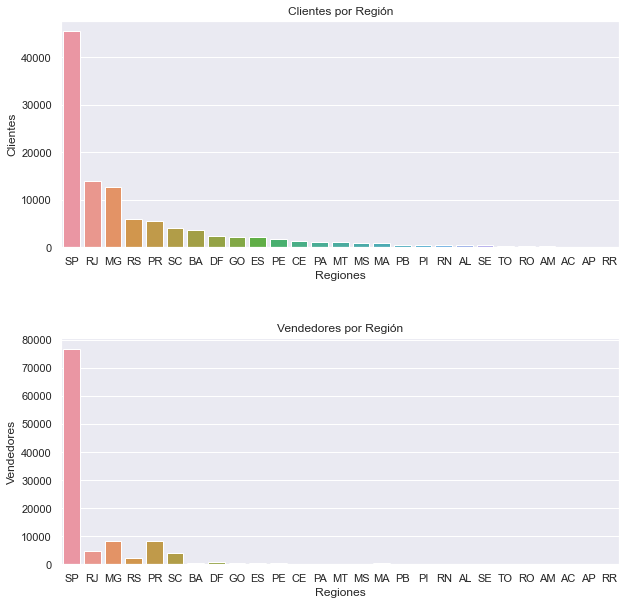

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

ax1.set_title('Clientes por Región')
sns.countplot(x='customer_state', data=olist_df, 
              order=olist_df.customer_state.value_counts().index, ax=ax1)
ax1.set_xlabel('Regiones')
ax1.set_ylabel('Clientes')


ax2.set_title('Vendedores por Región')
sns.countplot(x='seller_state', data=olist_df, 
              order=olist_df.customer_state.value_counts().index, ax=ax2)
ax2.set_xlabel('Regiones')
ax2.set_ylabel('Vendedores')

plt.subplots_adjust(hspace=0.4)
plt.show()

- Como era de esperarse el estado mas poblado y donde se encuentra la capital **SP: SAO PAULO** cuenta con la mayor cantidad de compradores y vendedores, mas del triple que las demás regiones.
- Las siguientes 5 posiciones por número de compradores y vendedores se mantienen sobre las mismas regiones:
    - **RJ: Rio de Janeiro**
    - **MG: Minas Gerais**
    - **RS: Rio grande do Sul**
    - **PR: Paraná**
    - **SC: Santa Catarina**
    
- Si la gran mayoria de compras realizadas son dentro del estado de **SP: SAO PAULO** es de esperarse que los tiempos de espera entre el momento de la compra y la entrega al cliente sean menores en comparación a las compras que requieren envíos interestatales. **¿Esto puede demostrarse desde los datos proporcionados?**

#### Tiempos de Entrega Reales vs Estimados

In [19]:
olist_df.days_from_approval_to_customer_delivery.describe()

count    107681.000000
mean         11.634374
std           9.413222
min           0.000000
25%           6.000000
50%           9.000000
75%          15.000000
max         208.000000
Name: days_from_approval_to_customer_delivery, dtype: float64

In [20]:
olist_df.days_from_approval_to_expected_delivery.describe()

count    107681.000000
mean         22.963132
std           8.852676
min          -2.000000
25%          18.000000
50%          22.000000
75%          28.000000
max         153.000000
Name: days_from_approval_to_expected_delivery, dtype: float64

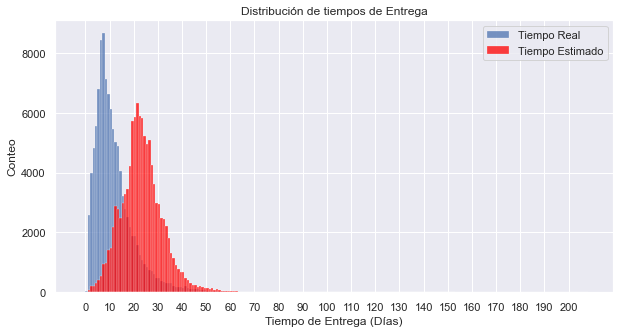

In [21]:
plt.figure(figsize=(10,5))
plt.title('Distribución de tiempos de Entrega')
sns.histplot(data=olist_df, x='days_from_approval_to_customer_delivery', binwidth=1, label='Tiempo Real')
sns.histplot(data=olist_df, x='days_from_approval_to_expected_delivery', binwidth=1, color='red', label='Tiempo Estimado')
plt.legend()
plt.xticks(range(0,210,10))
plt.xlabel('Tiempo de Entrega (Días)')
plt.ylabel('Conteo')
plt.show()

---

- Podemos notar que la distribución en tiempos de entrega reales tiene un sesgo a la derecha, aunque se encuentran distribuidos cerca a la media nacional de espera que es 11 días.

- Tambien se observa la politica conservadora de la empresa, respecto a los tiempos de entrega esperados donde la media es casi el doble de la espera real encontrada (22 días).

---

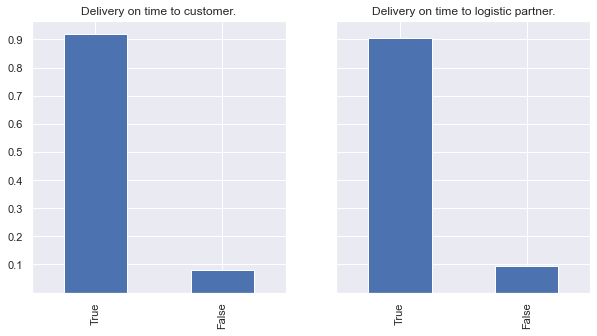

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharey=True)

olist_df.delivery_to_customer_on_time.value_counts(normalize=True).plot(kind='bar', ax=ax1)
ax1.set_title('Delivery on time to customer.')
ax1.set_yticks(np.arange(0.1, 1.1, 0.1))
olist_df.delivery_to_carrier_on_time.value_counts(normalize=True).plot(kind='bar', ax=ax2)
ax2.set_title('Delivery on time to logistic partner.')
plt.show()

---
Cerca del 90% en ambos casos, entregas al cliente y entregas al socio de logística son hechas dentro del tiempo límite.

Lo cual indica una coordinación muy importante entre los vendedores y socios. Sin embargo, este 10% de entregas tardías son cerca de 10mil entregas que no han llegado a tiempo, 
incluso con las políticas conservadoras de la empresa en cuanto a tiempo estimado de entrega.

---

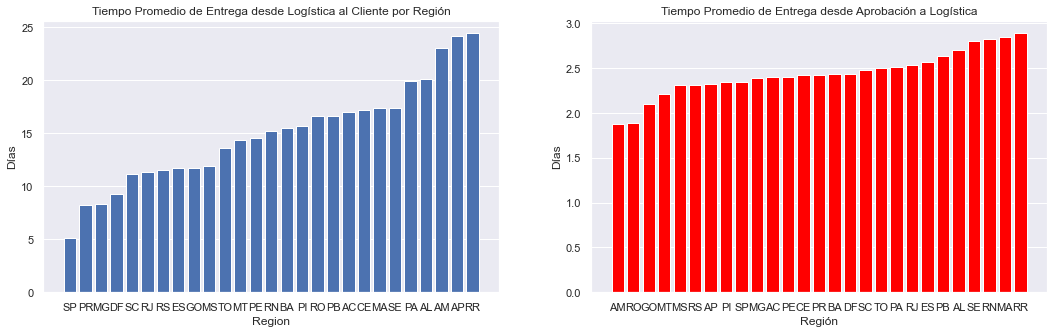

In [23]:
mean_days_approval_to_carrier_by_region = olist_df.groupby('customer_state').days_from_approval_to_carrier_delivery.mean().sort_values()
mean_days_carrier_to_customer = olist_df.groupby('customer_state').days_from_carrier_to_customer_delivery.mean().sort_values()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,5))
ax1.bar(x=mean_days_carrier_to_customer.index, height=mean_days_carrier_to_customer)
ax1.set_title('Tiempo Promedio de Entrega desde Logística al Cliente por Región')
ax1.set_xlabel('Region')
ax1.set_ylabel('Días')
ax1.grid(axis='x')

ax2.bar(x=mean_days_approval_to_carrier_by_region.index, height=mean_days_approval_to_carrier_by_region, color='red')
ax2.set_title('Tiempo Promedio de Entrega desde Aprobación a Logística')
ax2.set_xlabel('Región')
ax2.set_ylabel('Días')
ax2.grid(axis='x')

plt.show()

---

- Los tiempos de entrega desde el socio de logística al cliente, varían ampliamente siendo **SP: Sao Paulo** la región con tiempos muy inferiores respecto a todas las demás regiones.
    Es de esperarse, dado que la mayoría de ventas son realizadas en esta región, es normal que los socios de logística den prioridad a esta región.
    
- Por otra parte, existen regiones donde el tiempo de espera es muy superior a la media nacional, se hace interesante analizar si el promedio de calificación para estas regiones es menor al resto.

- Por último, se observa que el tiempo de entrega al socio de logística desde el momento de aprobación, es bastante similar en todas las regiones de 1.5 a 3 días.
---

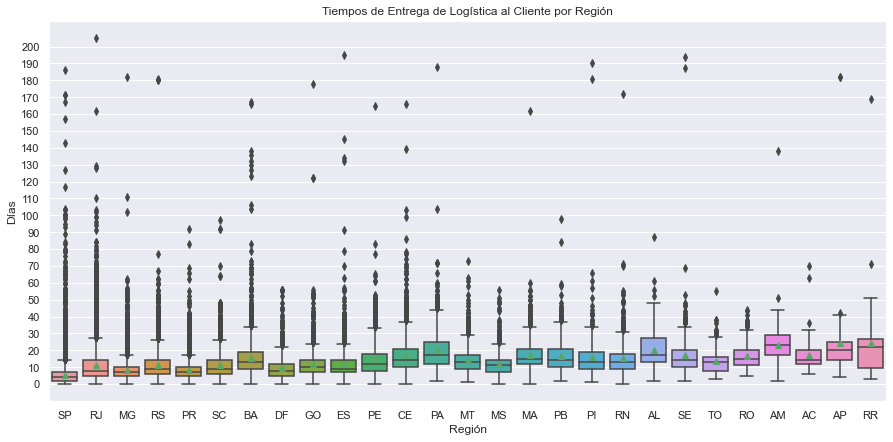

In [24]:
plt.figure(figsize=(15,7))
plt.title('Tiempos de Entrega de Logística al Cliente por Región')
sns.boxplot(x='customer_state', y='days_from_carrier_to_customer_delivery', data=olist_df, 
            order=olist_df.customer_state.value_counts().index, showmeans=True)
plt.xlabel('Región')
plt.ylabel('Días')
plt.yticks(range(0,210,10))
plt.show()

--- 

Podemos notar que la gran mayoría de entregas se encuentra dentro de los limites normales estimados por la empresa,
sin embargo existen múltiples entregas donde el tiempo de espera es muy superior a la media para cada estado.

No obstante, estas entregas por encima de la media no necesarimente son entregas "tardías" según los tiempos estimados de entrega por la empresa.

---

### Análisis de Entregas desde Logística al Cliente

Hemos podido observar que el mayor tiempo durante una compra transcurre desde que el socio de logística recibe los productos para su entrega.

Para avanzar un poco más en el estudio sobre el rendimiento de entregas, es importante considerar factores como:

1. El monto de la compra y el tipo de pago.
2. El estado donde procede el producto.
3. La temporada del año cuando se realiza la compra.


In [25]:
late_deliveries_to_customer = olist_df[olist_df.delivery_to_customer_on_time == False]
on_time_deliveries_to_customer = olist_df[olist_df.delivery_to_customer_on_time == True]

#### Entregas según el monto de la Compra y Métodos de Pago

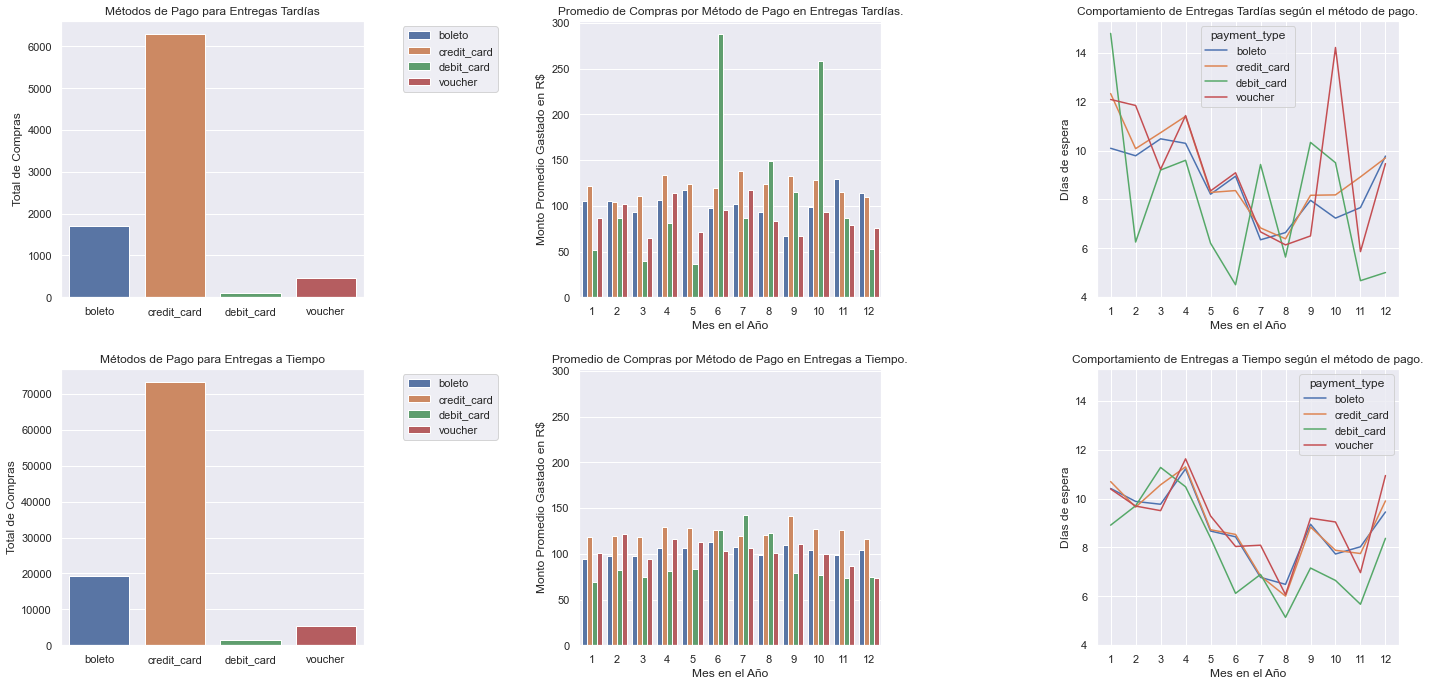

In [26]:
plt.figure(figsize=(20,10))

ax1 = plt.subplot(231); ax2 = plt.subplot(232); ax3 = plt.subplot(233)
ax4 = plt.subplot(234); ax5 = plt.subplot(235, sharey=ax2); ax6 = plt.subplot(236, sharey=ax3)

hue_order=['boleto','credit_card','debit_card','voucher']
sns.countplot(x='payment_type', data=olist_with_payments.loc[late_deliveries_to_customer.index], ax=ax1, order=hue_order)
ax1.set_title('Métodos de Pago para Entregas Tardías')
ax1.set_ylabel('Total de Compras')
ax1.set_xlabel('')

g = sns.barplot(x='month_of_delivery_to_customer', y='price', hue='payment_type',
                 data=olist_with_payments.loc[late_deliveries_to_customer.index], ax=ax2, ci=None, hue_order=hue_order)
g.legend(loc='upper left', bbox_to_anchor=(-0.6, 1.0))
ax2.set_title('Promedio de Compras por Método de Pago en Entregas Tardías.')
ax2.set_ylabel('Monto Promedio Gastado en R$')
ax2.set_xlabel('Mes en el Año')


sns.lineplot(x='month_of_delivery_to_customer', y='days_from_carrier_to_customer_delivery', hue='payment_type', 
             data=olist_with_payments.loc[late_deliveries_to_customer.index], err_style=None, ax=ax3, hue_order=hue_order)
ax3.set_title('Comportamiento de Entregas Tardías según el método de pago.')
ax3.set_ylabel('Días de espera')
ax3.set_xlabel('Mes en el Año')
ax3.set_xticks(range(1,13))

sns.countplot(x='payment_type', data=olist_with_payments.loc[on_time_deliveries_to_customer.index], ax=ax4, order=hue_order)
ax4.set_title('Métodos de Pago para Entregas a Tiempo')
ax4.set_ylabel('Total de Compras')
ax4.set_xlabel('')

g = sns.barplot(x='month_of_delivery_to_customer', y='price', hue='payment_type',
                 data=olist_with_payments.loc[on_time_deliveries_to_customer.index], ax=ax5, ci=None, hue_order=hue_order )
g.legend(loc='upper left', bbox_to_anchor=(-0.6, 1.0))
ax5.set_title('Promedio de Compras por Método de Pago en Entregas a Tiempo.')
ax5.set_ylabel('Monto Promedio Gastado en R$')
ax5.set_xlabel('Mes en el Año')


sns.lineplot(x='month_of_delivery_to_customer', y='days_from_carrier_to_customer_delivery', hue='payment_type', 
             data=olist_with_payments.loc[on_time_deliveries_to_customer.index], err_style=None, ax=ax6, hue_order=hue_order)
ax6.set_title('Comportamiento de Entregas a Tiempo según el método de pago.')
ax6.set_ylabel('Días de espera')
ax6.set_xlabel('Mes en el Año')
ax6.set_xticks(range(1,13))

plt.tight_layout(pad=2)
plt.show()

---

- Las compras mediante **tarjeta de crédito** son el método de pago más popular en la plataforma, cerca del 73% de las ventas se realizan por este medio.
    Seguido por compras con **boleto**, con un 20%. Estas proporciones se mantienen en las compras que se han entregado a tiempo o con retrasos.
    
- En cuanto a los montos gastados en cada mes, según el método de pago, no existe una tendencia clara aunque se puede destacar que en las entregas tardías a mitad de año los mayores montos se registraron en compras mediante voucher.

- Por último, los tiempos de entrega de las entregas hechas a tiempo, siguen una tendencia muy similar sin importar el método de pago. Mientras que las entregas tardías muestran unos claros picos en los tiempos de espera para los pagos mediante **tarjeta débito** y **voucher**

---

#### Entregas según el Estado de origen y destino

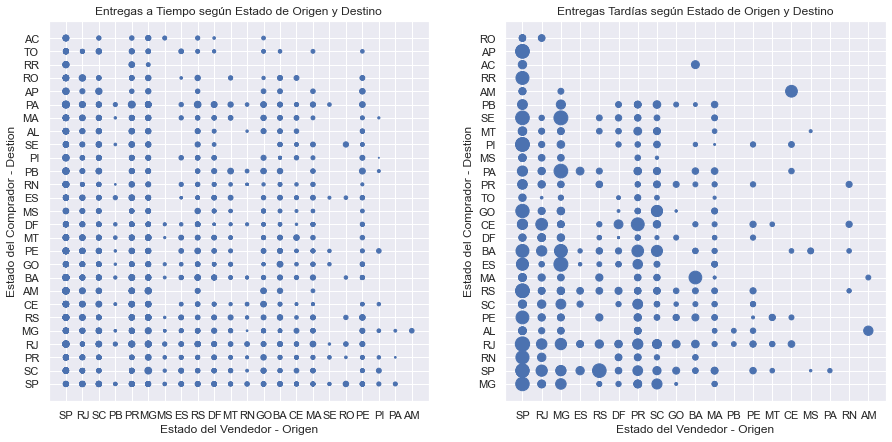

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

ax1.scatter(x='seller_state', y='customer_state', 
            s='days_from_carrier_to_customer_delivery', cmap='autumn_r',
            data=olist_df.loc[on_time_deliveries_to_customer.index])
ax1.set_title('Entregas a Tiempo según Estado de Origen y Destino')
ax1.set_xlabel('Estado del Vendedor - Origen')
ax1.set_ylabel('Estado del Comprador - Destion')

ax2.scatter(x='seller_state', y='customer_state', 
            s='days_from_carrier_to_customer_delivery', cmap='autumn_r',
            data=olist_df.loc[late_deliveries_to_customer.index])
ax2.set_title('Entregas Tardías según Estado de Origen y Destino')
ax2.set_xlabel('Estado del Vendedor - Origen')
ax2.set_ylabel('Estado del Comprador - Destion')
plt.show()

---

1. En primer lugar, los puntos azules indican el tiempo de espera promedio desde la fase de logística hasta el cliente, desde el estado de origen al destino.
    - Entre mayor sea el tamaño del punto azul, mayor es el tiempo medio de espera.
    
    
2. En las entregas a tiempo no se observan problemas de entrega, la mayoría de entregas se encuentran dentro de lo normal.

3. Por otra parte, en la figura de la derecha donde se muestran los tiempos de espera para las entregas tardías podemos notar un aumento importante en el tiempo de espera, 
    en otras palabras, cuando un pedido no llega a tiempo se demora mucho más de lo esperado.

---

#### Entregas según la fecha.

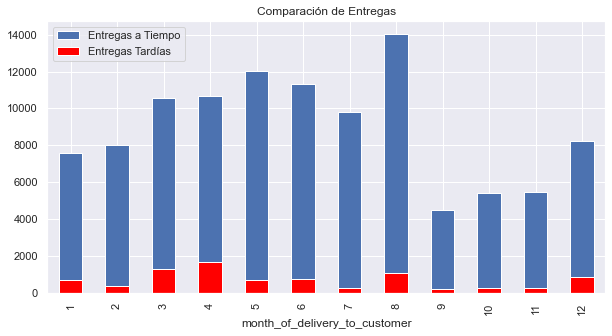

In [28]:
late_deliveries_by_month = olist_df.loc[late_deliveries_to_customer.index].groupby('month_of_delivery_to_customer').days_from_carrier_to_customer_delivery.size()
total_deliveries_by_month = olist_df.groupby('month_of_delivery_to_customer').size()

plt.figure(figsize=(10,5))
total_deliveries_by_month.plot(kind='bar', label='Entregas a Tiempo')
late_deliveries_by_month.plot(kind='bar', color='red', label='Entregas Tardías')
plt.title('Comparación de Entregas')
plt.legend(loc='upper left')
plt.show()


---

- Podemos notar una gran brecha en el número de entregas, y por lo tanto de compras, que se realizan a partir del octavo més, siendo los meses anteriores a Diciembre los de menor facturación en la plataforma.

- Los meses de mayor facturación se encuentran en la epoca central del año, sin embargo se puede notar que el número de entregas totales no afecta drasticamente el número de entregas tardías. Se observa que los meses de Mayo(05) y Junio(06) tienen mas entregas que los meses de Marzo(03) y Abril(04) y aun así tienen menos entregas tardías.

---


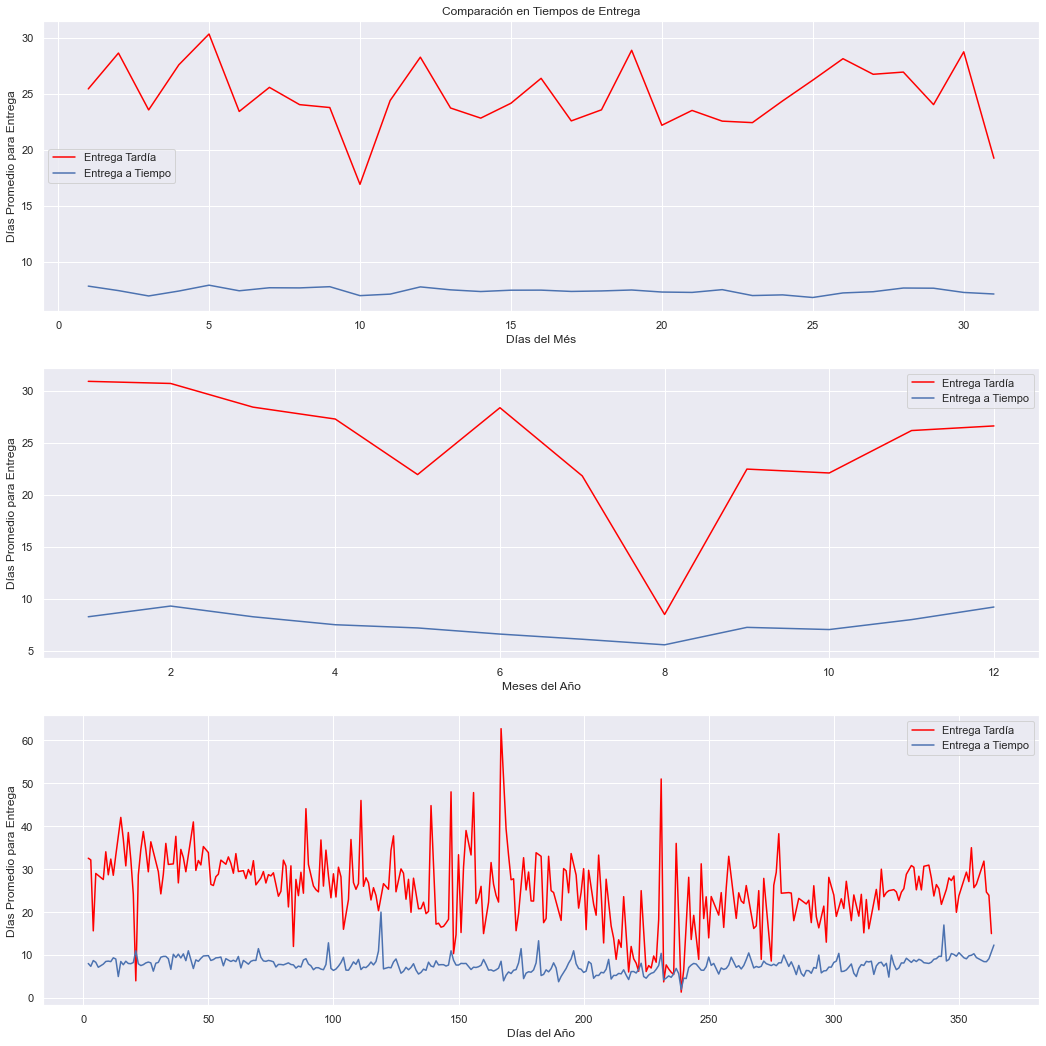

In [29]:

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,15))

late_orders = olist_df.loc[late_deliveries_to_customer.index]
orders_on_time = olist_df.loc[on_time_deliveries_to_customer.index]

sns.lineplot(x=late_orders['order_delivered_carrier_date'].dt.day, y=late_orders.days_from_carrier_to_customer_delivery, ci=None, color='red', ax=ax1, label='Entrega Tardía')
sns.lineplot(x=orders_on_time['order_delivered_carrier_date'].dt.day, y=orders_on_time.days_from_carrier_to_customer_delivery, ci=None, ax=ax1, label='Entrega a Tiempo')
ax1.set_title('Comparación en Tiempos de Entrega')
ax1.set_xlabel('Días del Més')
ax1.set_ylabel('Días Promedio para Entrega')

sns.lineplot(x=late_orders['order_delivered_carrier_date'].dt.month, y=late_orders.days_from_carrier_to_customer_delivery, ci=None, color='red', ax=ax2, label='Entrega Tardía')
sns.lineplot(x=orders_on_time['order_delivered_carrier_date'].dt.month, y=orders_on_time.days_from_carrier_to_customer_delivery, ci=None, ax=ax2, label='Entrega a Tiempo')
ax2.set_xlabel('Meses del Año')
ax2.set_ylabel('Días Promedio para Entrega')

sns.lineplot(x=late_orders['order_delivered_carrier_date'].dt.dayofyear, y=late_orders.days_from_carrier_to_customer_delivery, ci=None, color='red', ax=ax3, label='Entrega Tardía')
sns.lineplot(x=orders_on_time['order_delivered_carrier_date'].dt.dayofyear, y=orders_on_time.days_from_carrier_to_customer_delivery, ci=None, ax=ax3, label='Entrega a Tiempo')
ax3.set_xlabel('Días del Año')
ax3.set_ylabel('Días Promedio para Entrega')
plt.tight_layout(pad=2)
plt.legend()
plt.show()

---

Un aspecto muy preocupante para la empresa según lo observado en las anteriores gráficas, radica en que cuando los socios de logística fallan en entregar los productos antes de la fecha estimada, entonces los tiempos de espera para estos productos tardíos aumentan drásticamente. 

Esto puede indicar deficiencias en el manejo de los productos de parte de los socios de logística, como por ejemplo la existencia de un mal rastreo de los productos o rutas de entrega optimizadas, lo que ocasiona que estas entregas se queden retenidas en bodega esperando para su despacho por largos periodos de tiempo.

---

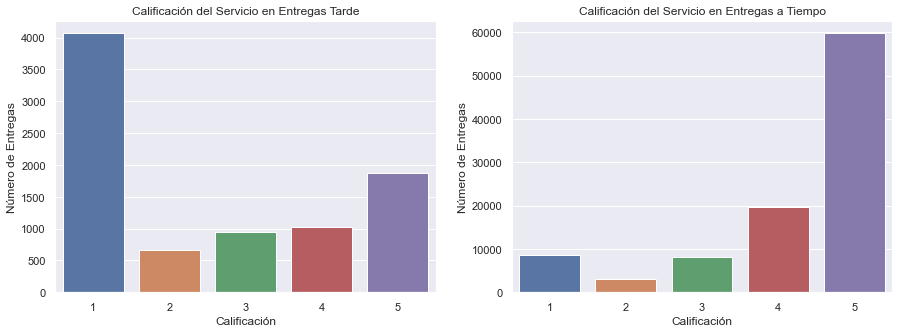

In [30]:
late_deliveries_review_score = olist_df.loc[late_deliveries_to_customer.index].review_score
on_time_deliveries_review_score = olist_df.loc[on_time_deliveries_to_customer.index].review_score

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

sns.countplot(x=late_deliveries_review_score, ax=ax1)
ax1.set_title('Calificación del Servicio en Entregas Tarde')
ax1.set_xlabel('Calificación')
ax1.set_ylabel('Número de Entregas')

sns.countplot(x=on_time_deliveries_review_score, ax=ax2)
ax2.set_title('Calificación del Servicio en Entregas a Tiempo')
ax2.set_xlabel('Calificación')
ax2.set_ylabel('Número de Entregas')
plt.show()

--- 

Por último, aunque las entregas tardías son cerca del 10% de todas las entregas que se realizan, se destaca que en la mayoría de entregas de este tipo, el usuario califica la entrega en el más bajo puntaje. 

---

### Conclusiones

1. La empresa OLIST tiene una política conservadora en cuanto a la estimación de fechas de entrega, sin embargo en los casos donde los pedidos se retrasan en la etapa de entrega esta estimación se queda corta.

2. En general, según el método de pago preferido por el cliente, no hay suficiente evidencia que permita demostrar que existe una preferencia en los tiempos de entrega. Sin embargo, si se nota una tendencia de los clientes a favorecer ciertas formas de pago según la temporada del año, lo cual permitiría a la empresa a construir campañas orientadas al consumo favoreciendo las compras por algún método en específico.

3. Dado que el estado capital concentra la gran mayoría de compras y ventas, sería prioritario para la empresa optimizar las rutas de entrega en este estado, dado que una gran cantidad de entregas retrasadas son originarias de este estado.

4. Hay una gran diferencia entre los tiempos medios de entrega para una entrega a tiempo y una entrega tardía, este es un gran indicador de falencias en el manejo de los productos por parte de los socios de logística.

5. Las entregas tardías son un gran problema en la plataforma, resaltado por la calificación asignada por los usuarios, y pueden afectar la imagen de la empresa negativamente.

## Predicción de Entregas Tardías usando Machine Learning

Dada la importancia de las entregas tardías a los ojos de los compradores, es fundamental para la empresa identificar de manera temprana los factores que pueden ocasionar una demora en las entregas, aunque existen factores externos dificiles de controlar para OLIST como son la optimización de las rutas y frecuencia de entregas por parte de los socios de logística. 
Si es posible identificar otro tipo de factores como son el origen y destino de las ventas, la temporada del envío, la categoría del envío, entre otras y construir un modelo de machine learning que nos permita identificar si una entrega tiene una mayor posibilidad de ser entregada tarde. 

### Eliminar columnas no usadas en la predicción

Las columnas que se eliminan en este punto del dataset, son borradas porque introducen información al sistema que no debería conocerce al momento de realizarse la compra, como por ejemplo, los días desde la aprobación de la compra hasta la entrega al cliente. Sin embargo, como anteriormente se demostró que los días desde la compra hasta la entrega a logística son muy similares en todos los estados, esta información si se mantendrá.

In [31]:
columns_to_delete = ['order_status', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'shipping_limit_date', 'review_score', 
                     'days_from_approval_to_expected_delivery', 'days_from_approval_to_customer_delivery', 'days_from_carrier_to_customer_delivery', 'month_of_delivery_to_customer']

olist_df.drop(columns_to_delete, axis=1, inplace=True)

### Transformar Datos Categóricos

In [32]:
categorical_columns = ['product_category_name_english', 'seller_city', 'seller_state', 'customer_city', 'customer_state']
for col in categorical_columns:
    olist_df[col] = olist_df[col].astype('category').cat.codes


### Transformar Series de Tiempo a Datos Puntuales

In [33]:
timestamp_columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date']

for col in timestamp_columns:
    olist_df[f'{col}_year'] = olist_df[col].dt.year
    olist_df[f'{col}_month'] = olist_df[col].dt.month
    olist_df[f'{col}_day'] = olist_df[col].dt.day
    olist_df[f'{col}_is_weekend'] = (olist_df[col].dt.weekday // 5) == 1 

# Eliminamos las columnas con timestamp
olist_df.drop(timestamp_columns, axis=1, inplace=True)

### Análisis de Correlación

<AxesSubplot:>

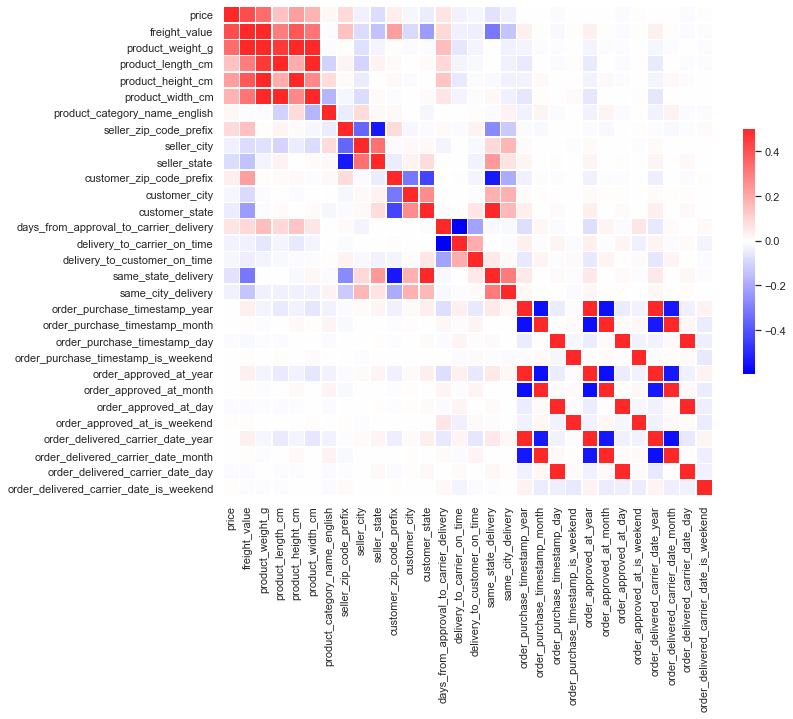

In [34]:
corr = olist_df.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap='bwr', vmax=.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

---

La variable objetivo en nuestro modelo es **delivery_to_customer_on_time**, dado que queremos predecir si la entrega será llevada en el tiempo previsto al cliente.

De la tabla de correlación podemos resaltar algunas características interesantes respecto a la variable objetivo:

1. Existe una leve correlación inversa entre los días desde la aprobación de la compra hasta la entrega a logística, con la entrega a tiempo al cliente.
    Es decir, entre mas pronto el vendedor disponga sus productos a logística, mayor es la posibilidad que esta sea entregada en el tiempo estimado. 
    Esto se puede observar igualmente en la variable que indica si la entrega fue hecha a tiempo a la logística, con una correlación directa con la variable objetivo.
    
2. En general, las demás características tienen una correlación muy leve con la variable objetivo.

---

### Métricas de Evaluación

Nuestra variable objetivo es **delivery_to_customer_on_time**, una variable booleana que indica si la compra fue entregada antes de la fecha estimada al cliente.

Si la empresa decidiera, decidiera de cierta manera con los compradores por la demora en la entrega, por ejemplo ofreciendo descuentos o envíos gratis en las futuras compras.
Se hace relevante, analizar los posibles casos de la predicción de nuestro modelo.

- **Fallo Tipo 1**: El modelo predice que la entrega se hará después de la fecha estimada, y la empresa decide disculparse con el cliente enviando descuentos. 
    - Sin embargo, la entrega se realizó a tiempo y la empresa terminó entregando una disculpa que no era necesaria.
    
    
- **Fallo Tipo 2**: El modelo predice que la entrega se hará a tiempo, por lo que el cliente no recibe ninguna disculpa o notificación por parte de la empresa.
    - No obstante, el tiempo de entrega fue superior a los limites estimados, y el cliente muy posiblemente otorgue una mala clasificación al vendedor.
    
En este punto para escoger cual de estos fallos se le debería dar mayor prioridad al momento de entrenar un model de machine learning, sería necesario conocer las objetivos de la empresa.
De momento, podemos definir nuestro objetivo de entrenamiento como minimizar estos dos fallos lo más posible, o en términos más técnicos un modelo que maximize **recall** y **precision** en la clasificación de las entregas. 

- **Precision**: De las entregas que el modelo predice que **no llegarán a tiempo**, cuantas realmente no llegaron a tiempo?

- **Recall**: De las entregas que **no llegaron a tiempo**, cuantas ha clasificado correctamente el modelo?

In [35]:
# importar las librerías necesarias
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Modelos de Clasificación
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

### Separar los datos en 80% para Entrenamiento y 20% para Test

In [36]:
x_train = olist_df.drop('delivery_to_customer_on_time', axis=1)
y_train = olist_df['delivery_to_customer_on_time']

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.2, random_state = 73)

### Evaluar los algoritmos de clasificación

In [37]:
def run_experiments(X_train, y_train, X_test, y_test, threshold=0.5):        
    estimators = [
          ('Random Forest',  RandomForestClassifier(criterion='gini', n_estimators=200, n_jobs=-1, random_state=73, class_weight='balanced')),
          ('Gradient Boosting', GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, random_state=73)),
          ('Logistic Regression', LogisticRegression(solver='liblinear', class_weight='balanced', random_state=73))
    ]
    
    target_names = ['Late Deliver', 'On time Deliver']
    
    for name, model in estimators:
        classifier = model.fit(X_train, y_train)
        y_pred_proba = classifier.predict_proba(X_test)
        y_pred = (y_pred_proba [:,1] >= threshold).astype('int')
        
        print(name)
        print(classification_report(y_test, y_pred, target_names=target_names))
        print(confusion_matrix(y_test, y_pred))
        print('----')
        
    return estimators

In [38]:
_ = run_experiments(x_train, y_train, x_test, y_test)

Random Forest
                 precision    recall  f1-score   support

   Late Deliver       0.86      0.24      0.37      1737
On time Deliver       0.94      1.00      0.97     19800

       accuracy                           0.94     21537
      macro avg       0.90      0.62      0.67     21537
   weighted avg       0.93      0.94      0.92     21537

[[  409  1328]
 [   68 19732]]
----
Gradient Boosting
                 precision    recall  f1-score   support

   Late Deliver       0.54      0.20      0.30      1737
On time Deliver       0.93      0.99      0.96     19800

       accuracy                           0.92     21537
      macro avg       0.74      0.59      0.63     21537
   weighted avg       0.90      0.92      0.91     21537

[[  352  1385]
 [  295 19505]]
----
Logistic Regression
                 precision    recall  f1-score   support

   Late Deliver       0.15      0.57      0.24      1737
On time Deliver       0.95      0.72      0.82     19800

       accura

### Balanceo de Clases

Como ya habíamos observado en la exploración inicial de datos, las entregas tarde son cerca del 10% de las entregas totales, 
esto nos interea antes de crear un modelo de clasificación porque tenemos un desbalance de clases importante.
Esto puede ocasionar que nuestro modelo, no tenga los suficientes ejemplos para reconocer tempranamente cuando una entrega será realizada tarde como observamos en los resultados anteriores.

Podemos ver que en nuestros datos de entrenamiento, las entregas tarde son tan solo el 8% de los datos, lo cual dificulta la identificación mas acertada de las entregas tardías.

In [39]:
print('Número de muestras de entrenamiento.')
y_train.value_counts()

Número de muestras de entrenamiento.


True     79306
False     6838
Name: delivery_to_customer_on_time, dtype: int64

#### Smote para balancear clases

Al usar esta técnica, podemos cumplir dos objetivos:

1. Reducir la cantidad de muestras de la clase mayoritaria, para evitar sobreentrenar nuestros modelos sobre estas muestras.

2. Generar datos sintéticos de la clase minoritaria, selecccionando muestras que estan cercanas en el espacio de características y extrapolando nuevas muestras de esta forma.

In [40]:
import imblearn

under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.5)
over = imblearn.over_sampling.SMOTE(sampling_strategy=0.2, k_neighbors=11)

steps = [('o', over), ('u', under)]
pipeline = imblearn.pipeline.Pipeline(steps=steps)

x_train, y_train = pipeline.fit_resample(x_train, y_train)

In [41]:
print('Número de muestras de entrenamiento después de aplicar SMOTE')
y_train.value_counts()

Número de muestras de entrenamiento después de aplicar SMOTE


True     31722
False    15861
Name: delivery_to_customer_on_time, dtype: int64

In [42]:
estimators = run_experiments(x_train, y_train, x_test, y_test)

Random Forest
                 precision    recall  f1-score   support

   Late Deliver       0.42      0.42      0.42      1737
On time Deliver       0.95      0.95      0.95     19800

       accuracy                           0.91     21537
      macro avg       0.69      0.69      0.69     21537
   weighted avg       0.91      0.91      0.91     21537

[[  732  1005]
 [ 1007 18793]]
----
Gradient Boosting
                 precision    recall  f1-score   support

   Late Deliver       0.33      0.39      0.36      1737
On time Deliver       0.95      0.93      0.94     19800

       accuracy                           0.89     21537
      macro avg       0.64      0.66      0.65     21537
   weighted avg       0.90      0.89      0.89     21537

[[  679  1058]
 [ 1379 18421]]
----
Logistic Regression
                 precision    recall  f1-score   support

   Late Deliver       0.14      0.56      0.22      1737
On time Deliver       0.95      0.70      0.81     19800

       accura

---

De los modelos generados, podemos observar que el sobremuestreo de la clase minoritaria permitió mejorar en cierta manera, la generalización de nuestros modelos sobre la clase minoritaria,
no obstante aun cuando estos resultados están lejos de tener una gran certeza, podemos desde el mejor modelo obtenido basado en **Random Forest** identificar el 43% de las entregas tardías,
y desde este punto podemos empezar a mejorar la percepción de los clientes sobre la plataforma.

---

### Importancia de las Características

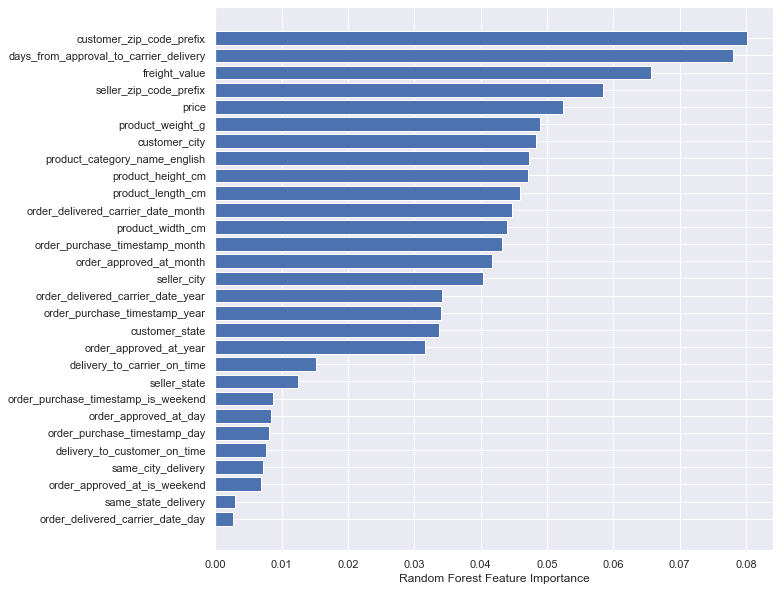

In [43]:
_, rf = estimators[0]
plt.figure(figsize=(10,10))
sorted_idx = rf.feature_importances_.argsort()
plt.barh(olist_df.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.show()

Para terminar podemos analizar la importancia de las características para el mejor modelo obtenido:

1. Como era de esperarse, la ubicación del vendedor y el comprador tienen una gran importancia en la predicción de una entrega a tiempo, siendo Brazil el país mas grande de latino-américa esta característica dificilmente cambiará sin mejorar la disponibilidad de rutas por parte de los socios de logística.

2. El tiempo de entrega de los productos desde el vendedor a logística, es una característica importante para el modelo, aún cuando vimos que el tiempo promedio de esta entrega es bastante similar en todos los estados. Parece que una entrega tardía a logística, influye bastante en la decisión. 

3. El precio del producto, y el costo del envío influyen bastante en la decisión del modelo. Esto puede entenderse porque un envío de mayor valor tendrá una mayor prioridad en la entrega, por parte tanto del vendedor como de logística.

4. Las dimensiones del producto, y la categóría del producto tambien son relevantes para el modelo al determinar la posibilidad que un producto no sea entregado a tiempo.